# Scorecard development with `optbinning` and lasso

As a data scientist working for a bank, it's a daily task to develop credit risk models to classify the applicants as low risk client and high risk clients.

Scorecard is a very commonly used tool to develop this risk score. At this time of data age, you can get hundreds of thousands variables that you can use to train your scorecard model. Some model developers would use step-wise method to stepwisely add or delete variables to the model until there is no improvement.

I would like to use L-1 regularization (also known as lasso) and cross-validation to eliminate redundant variables and find the best model.

## Scorecard

One of the significant differences between scorecard and logistic regression is that you need to bin the features in to several categories and use $WOE$ instead of the original features to calculate the $PD$ (probability of default). What you will get from a scorecard is not a probabilty. The common operation is to convert that probability to an integer score so that your bank manager can commucate with you about your credit score instead of a bizzare $0.897$ probability.



## Too many features

Nowadays we face an enviroment where there is too much data instead of too little data to model with. In the process of modeling, we need to choose the most important features to our target and eliminate those superfluous features. For example, some features can be highly correlated and one of them is enough for our modeling. In Statistical Modeling, we can this phenomenon as multi-collinearity. When we are estimationg a regression model, multicollinearity can lead to inflated standard errors of the estimated parameters and unstable/bad models.

In this example, I am going to introduce the L1 regularization that is used to diminish the feature redundancy problems.

$$y = x + 1$$


## How to do it in python

I am going to demonstrate how I would do it in Python with some simulated data. In practice, you will find yourself facing a dataset with millions of clients and thousands of features. The methodology is the same.

In [1]:
import numpy as np
import pandas as pd
from optbinning import OptimalBinning, BinningProcess

from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Parameters
n_samples = 10000  # Number of samples
n_features = 50  # Number of features
n_informative = 15  # Number of informative features
n_redundant = 20  # Number of redundant features
n_classes = 2  # Number of classes

# Generate the data
X, y = make_classification(n_samples=n_samples,
                           n_features=n_features,
                           n_informative=n_informative,
                           n_redundant=n_redundant,
                           n_classes=n_classes,
                           random_state=77)

# Convert to DataFrame for easier manipulation
col_names = [f'feature_{i}' for i in range(n_features)]
df = pd.DataFrame(X, columns=col_names)
df['y'] = y

# Display the first few rows of the dataframe
print(df.head())

(CVXPY) Aug 01 11:57:56 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Aug 01 11:57:56 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -1.536300   0.032864  -0.806332  -1.395862   0.330722  -2.044779   
1  -0.978616   1.141064 -12.185030   0.350312   4.117984  -3.590603   
2   1.014014   1.068655   7.173429   0.602360   5.271167  -4.403746   
3  -1.413498  -0.150704 -16.068619   0.157056   0.400892  -3.769886   
4   0.347396   2.245533  -1.356054   0.077063   7.396746   0.226702   

   feature_6  feature_7  feature_8  feature_9  ...  feature_41  feature_42  \
0   3.370804 

<Axes: >

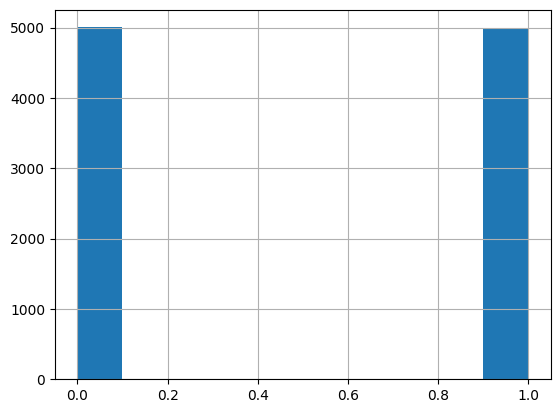

In [2]:
df.y.hist()

/var/folders/jy/yrf0_2sx3v3gzgjl01s2_8sc0000gn/T/ipykernel_13795/1951943532.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="y"
/var/folders/jy/yrf0_2sx3v3gzgjl01s2_8sc0000gn/T/ipykernel_13795/1951943532.py:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x="y"


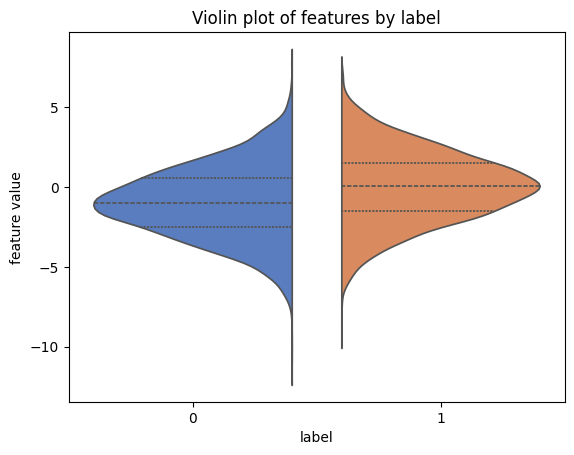

In [12]:
import seaborn as sns

# Create a violin plot with customizations
sns.violinplot(x="y"
               , y="feature_3"
               , data=df
               , split=True
               , inner="quartile"
               , palette="muted"
               , scale="count")

# Add a title and labels
plt.title('Violin plot of features by label')
plt.xlabel('label')
plt.ylabel('feature value')

# Show the plot
plt.show()

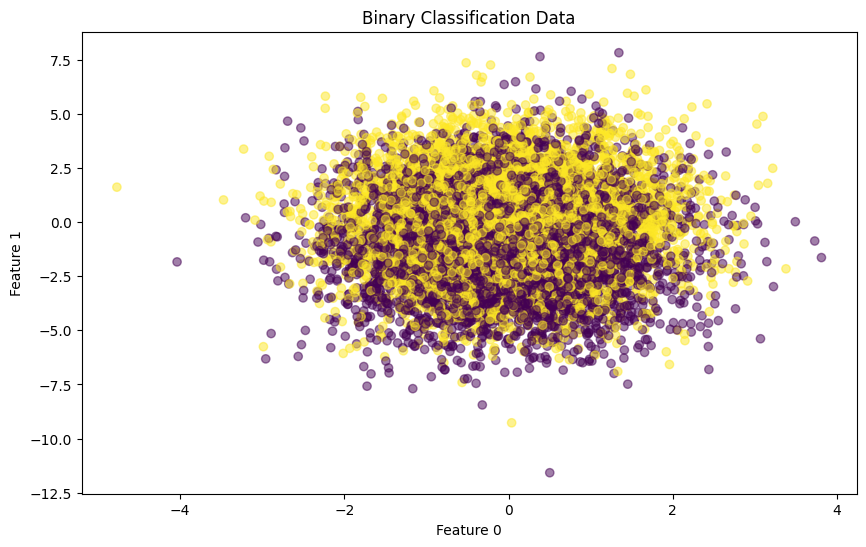

In [15]:
# Visualize the first two features
plt.figure(figsize=(10, 6))
plt.scatter(df['feature_0'], df['feature_3'], c=df['y'], cmap='viridis', alpha=0.5)
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title('Binary Classification Data')
plt.show()

In [25]:
# split into training, validation and test set

from sklearn.model_selection import train_test_split

# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# df_test is going to be our left out test sample
df_train_, df_test = train_test_split(df
                 , test_size=0.15
                 , random_state=77)

df_train, df_val = train_test_split(df_train_
                 , test_size=0.2
                 , random_state=77)

print(f'The sizes of train, validation and test sets are {df_train.shape[0]}, {df_val.shape[0]}, {df_test.shape[0]}.')

The sizes of train, validation and test sets are 6800, 1700, 1500.


## The Binning Process

We will use [OptBinning](http://gnpalencia.org/optbinning/) to do the binning part. If you are interested, you can visit the home page of the package. Here is the introduction from thier website.

> The optimal binning is the optimal discretization of a variable into bins given a discrete or continuous numeric target. OptBinning is a library written in Python implementing a rigorous and flexible mathematical programming formulation to solve the optimal binning problem for a binary, continuous and multiclass target type, incorporating constraints not previously addressed.

In [28]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title="Pandas Profiling Report")
# profile

In [31]:
# # Convert to DataFrame for easier manipulation (optional)
# df_train = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(n_features)])
# df_train['y'] = y_train

# df_val = pd.DataFrame(X_val, columns=[f'feature_{i}' for i in range(n_features)])
# df_val['y'] = y_val

# Display the shape of the resulting datasets
print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')


selection_criteria = {"iv": {"min": 0.02}}

binning_process = BinningProcess(variable_names=col_names
                                 , min_prebin_size=0.01
                                 , max_n_bins=None
                                 , min_bin_size=0.05
                                 , selection_criteria=selection_criteria
                                 , n_jobs=None)

variable_names = col_names

binning_process.fit(df_train.loc[:, variable_names], df_train.loc[:, 'y'])

df_train_woe = binning_process.transform(df_train.loc[:, variable_names]
                                         , metric='woe'
                                         , metric_missing='empirical')

df_train_woe.head()

Training set shape: (6800, 51)
Validation set shape: (1700, 51)


,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_10,feature_11,feature_13,feature_15,...,feature_31,feature_33,feature_36,feature_38,feature_39,feature_42,feature_44,feature_45,feature_46,feature_47
3803,-0.123072,-0.419578,0.104299,0.550390,0.097846,-0.263952,-0.230185,-0.216554,-0.122229,0.417871,...,0.277297,-0.141693,-0.037931,-0.016599,-0.054531,0.216898,0.210784,0.241228,-0.469244,-0.144420
8835,0.226170,0.191329,0.018241,-0.334270,0.024800,0.315410,0.171964,0.216772,0.251526,0.226038,...,-0.035865,0.075466,0.304688,-0.078707,0.099577,-0.345307,0.210784,0.317952,-0.157952,0.493666
5160,-0.788035,-0.199733,0.018241,0.044143,0.097846,-0.907617,-1.680300,0.216772,0.251526,0.226038,...,-0.432076,-0.359383,-0.037931,-0.078707,-0.605963,-1.035406,-0.413324,-0.091193,0.089017,-0.543562
3671,0.797995,1.012903,0.018241,0.044143,-0.354152,0.662739,1.458731,-0.409445,-0.122229,0.226038,...,-0.432076,1.494694,0.599809,0.462864,0.714507,1.769209,-0.176088,0.241228,-0.180186,0.493666
3082,0.532292,-0.419578,0.018241,0.044143,0.024800,0.168789,0.171964,-0.216554,-0.122229,0.028422,...,0.256870,-0.359383,0.222004,-0.212553,-0.054531,-1.035406,-0.413324,-0.125976,-0.180186,-0.543562


In [32]:
variables_bin_selected = binning_process.get_support(names=True)

# the binning table for one variable
binning_process.get_binned_variable(variables_bin_selected[0]).binning_table.build(add_totals=True)

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -3.61)",591,0.086912,407,184,0.311337,0.797995,0.052625,0.006409
1,"[-3.61, -2.56)",647,0.095147,407,240,0.370943,0.532292,0.026354,0.003256
2,"[-2.56, -0.57)",2062,0.303235,1145,917,0.444714,0.22617,0.015449,0.001927
3,"[-0.57, 0.23)",929,0.136618,435,494,0.531755,-0.123072,0.002066,0.000258
4,"[0.23, 1.76)",1440,0.211765,611,829,0.575694,-0.301006,0.019037,0.002371
5,"[1.76, 2.41)",422,0.062059,167,255,0.604265,-0.419152,0.010742,0.001333
6,"[2.41, inf)",709,0.104265,221,488,0.688293,-0.788035,0.061546,0.007500
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,6800,1.000000,3393,3407,0.501029,,0.187819,0.023054


In [33]:
binning_process.get_binned_variable(variables_bin_selected[0]).binning_table.analysis()

binning_process.get_binned_variable(variables_bin_selected[4]).binning_table.iv

binning_process.get_binned_variable(variables_bin_selected[4]).binning_table.quality_score

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.23839426
    IV (Jeffrey)             0.18781890
    JS (Jensen-Shannon)      0.02305382
    Hellinger                0.02326263
    Triangular               0.09061211
    KS                       0.18376375
    HHI                      0.18678936
    HHI (normalized)         0.08513803
    Cramer's V               0.21285215
    Quality score            0.42078612

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic  p-value     P[A > B]  P[B > A]
        0      1     4.873079 0.027279 1.308609e-02  0.986914
        1      2    10.953398 0.000934 4.098044e-04  0.999590
        2      3    19.470696 0.000010 2.473954e-07  1.000000
        3      4     4.421496 0.035489 1.746609e-02  0.982534
        4      5     1.095205 0.295321 1.462048e-01  0.853795
      

0.04674318005888588

In [34]:
# logistic regression

from sklearn.model_selection import GridSearchCV

C_grid = np.logspace(-4, 4, 10)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l1', solver='liblinear')

from sklearn.metrics import roc_auc_score

param_grid = {'C': C_grid}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(df_train_woe, df_train.loc[:, 'y'])

best_model = grid_search.best_estimator_
best_C = grid_search.best_params_['C']

df_coef = pd.DataFrame({'var': df_train_woe.columns, 'coef': best_model.coef_[0]})

df_coef

,var,coef
0,feature_3,-1.076717
1,feature_4,-0.718981
2,feature_5,-0.278929
3,feature_6,-0.833082
4,feature_7,-0.850601
5,feature_8,0.623277
6,feature_10,-0.234278
7,feature_11,-0.096285
8,feature_13,-0.868184
9,feature_15,0.139272


In [38]:
vars_to_delete = df_coef.loc[df_coef.coef > 0, 'var'].tolist()
vars_to_keep = df_coef.loc[df_coef.coef < 0, 'var'].tolist()

len(vars_to_delete), len(vars_to_keep)

(3, 24)

(array([1180.,  704.,  564.,  517.,  440.,  438.,  489.,  541.,  720.,
        1207.]),
 array([5.41096672e-04, 1.00439577e-01, 2.00338058e-01, 3.00236538e-01,
        4.00135019e-01, 5.00033499e-01, 5.99931980e-01, 6.99830460e-01,
        7.99728941e-01, 8.99627421e-01, 9.99525902e-01]),
 <BarContainer object of 10 artists>)

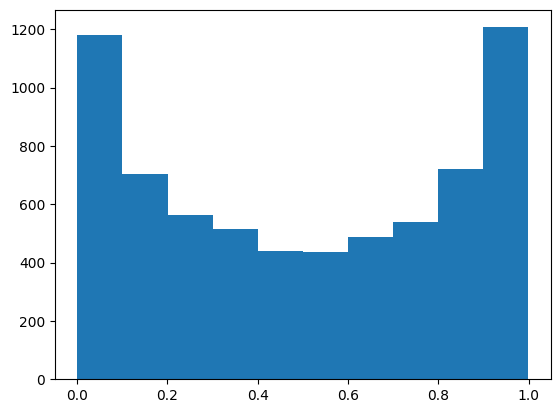

In [39]:
# 分数分布
import matplotlib.pyplot as plt

plt.hist(best_model.predict_proba(df_train_woe)[:, 1])

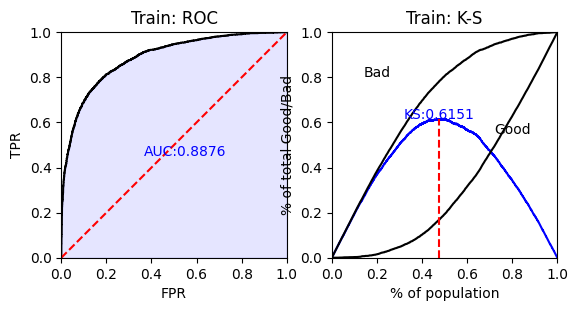

{'KS': 0.6151,
 'AUC': 0.8876,
 'Gini': 0.7751,
 'pic': <Figure size 640x480 with 2 Axes>}

In [41]:
# performance
import scorecardpy as sc
sc.perf_eva(df_train.loc[:, 'y'], best_model.predict_proba(df_train_woe)[:, 1], plot_type=['roc', 'ks'], title='Train')

In [42]:
df_test_woe = binning_process.transform(df_test.loc[:, variable_names]
                                       , metric='woe'
                                       , metric_missing='empirical')
df_test_woe.head()

,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_10,feature_11,feature_13,feature_15,...,feature_31,feature_33,feature_36,feature_38,feature_39,feature_42,feature_44,feature_45,feature_46,feature_47
7410,-0.419152,0.967046,0.104299,0.291800,-0.148462,-0.263952,0.478803,0.216772,0.408210,-0.670880,...,-1.046000,1.494694,0.222004,-0.078707,0.099577,1.769209,0.572513,0.317952,0.488294,0.493666
261,-0.788035,0.967046,0.018241,-0.334270,0.097846,-0.907617,-0.532358,-0.409445,-0.122229,-0.350595,...,-1.046000,-0.141693,0.304688,-0.212553,-0.605963,-0.345307,0.572513,-1.016786,0.089017,-0.027299
8425,0.532292,0.039386,0.018241,0.044143,0.097846,0.168789,0.171964,0.216772,0.408210,0.226038,...,0.277297,-0.359383,0.304688,-0.078707,-0.341384,1.769209,0.572513,-0.002355,0.089017,0.493666
722,-0.301006,-0.419578,-1.030779,-0.334270,-0.148462,-0.263952,0.171964,0.216772,0.408210,-0.350595,...,-0.035865,-0.554584,-0.578129,-0.016599,0.714507,-1.528194,-0.176088,-0.125976,0.488294,-0.144420
3106,-0.419152,-0.419578,0.018241,0.044143,-0.148462,-0.263952,0.171964,0.216772,0.408210,-0.906359,...,-1.046000,-0.141693,0.383708,0.462864,0.289986,0.943619,0.210784,-0.125976,1.021988,0.493666


In [43]:
best_model.predict_proba(df_test_woe)[:, 1]

array([0.13021353, 0.96611963, 0.01710373, ..., 0.46757198, 0.62933752,
       0.05179221])

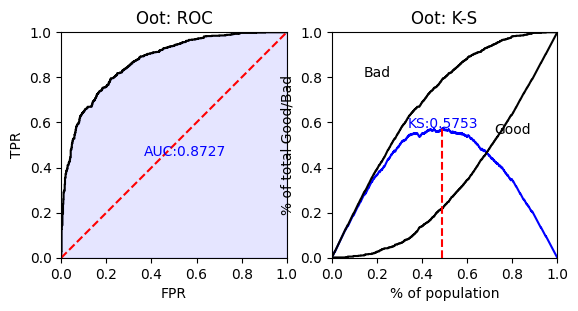

{'KS': 0.5753,
 'AUC': 0.8727,
 'Gini': 0.7454,
 'pic': <Figure size 640x480 with 2 Axes>}

In [45]:
sc.perf_eva(df_test.loc[:, 'y'], best_model.predict_proba(df_test_woe)[:, 1], plot_type=['roc', 'ks'], title='Oot')

In [47]:
df_coef.head()

,var,coef
0,feature_3,-1.076717
1,feature_4,-0.718981
2,feature_5,-0.278929
3,feature_6,-0.833082
4,feature_7,-0.850601


In [50]:
df_binning.head()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Variable,Coef
0,"(-inf, -3.61)",591,0.086912,407,184,0.311337,0.797995,0.052625,0.006409,feature_3,-1.073779
1,"[-3.61, -2.56)",647,0.095147,407,240,0.370943,0.532292,0.026354,0.003256,feature_3,-1.073779
2,"[-2.56, -0.57)",2062,0.303235,1145,917,0.444714,0.226170,0.015449,0.001927,feature_3,-1.073779
3,"[-0.57, 0.23)",929,0.136618,435,494,0.531755,-0.123072,0.002066,0.000258,feature_3,-1.073779
4,"[0.23, 1.76)",1440,0.211765,611,829,0.575694,-0.301006,0.019037,0.002371,feature_3,-1.073779


iteration 1
remaining variable number 24


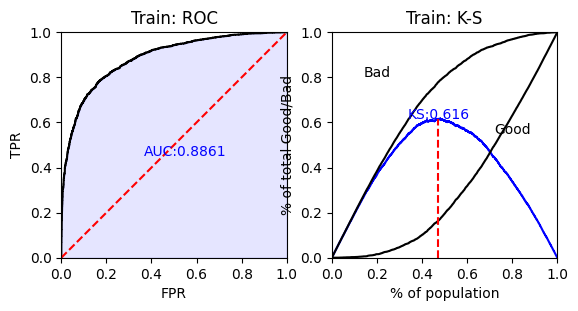

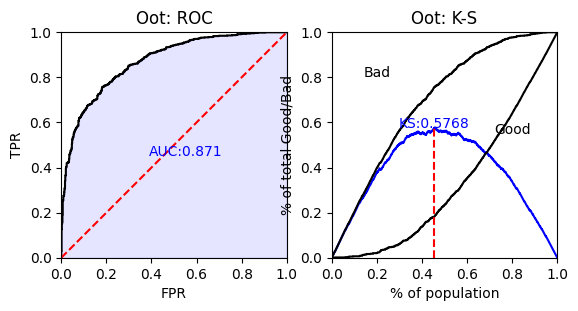

In [51]:
# 处理coef方向不对问题

pdo = 20
target_score = 500
target_odds = 1 / 20
i = 1

while True:
    print(f'iteration {i}')
    initial_n_vars = len(vars_to_keep)

    print(f'remaining variable number {initial_n_vars}')

    model_exp3 = LogisticRegression(solver='liblinear', penalty='l1', C=best_C)
    model_exp3.fit(df_train_woe.loc[:, vars_to_keep], df_train.loc[:, 'y'])

    df_coef_exp3 = pd.DataFrame({'var': vars_to_keep, 'coef': model_exp3.coef_[0]})
    df_coef_exp3.merge(df_coef, how='left', on='var')

    sc.perf_eva(df_train.loc[:, 'y'], model_exp3.predict_proba(df_train_woe.loc[:, vars_to_keep])[:, 1], plot_type=['roc', 'ks'],
                title='Train')
    sc.perf_eva(df_test.loc[:, 'y'], model_exp3.predict_proba(df_test_woe.loc[:, vars_to_keep])[:, 1], plot_type=['roc', 'ks'], title='Oot')

    A = target_score - pdo / np.log(2) * np.log(target_odds)

    score_intercept = A - pdo / np.log(2) * model_exp3.intercept_[0]

    list_score_table = []

    for var_bin in vars_to_keep:
        df_binning = binning_process.get_binned_variable(var_bin).binning_table.build(add_totals=False)

        df_binning.loc[:, 'Variable'] = var_bin

        df_binning.loc[:, 'Coef'] = df_coef_exp3.loc[df_coef_exp3.loc[:, 'var'] == var_bin, 'coef'].values[0]

        df_binning.loc[:, 'score'] = -pdo / np.log(2) * df_binning.loc[:, 'Coef'] * df_binning.loc[:, 'WoE']

        list_score_table.append(df_binning)

    df_score_table = pd.concat(list_score_table, axis=0)

    df_var_score_range = df_score_table.groupby('Variable', as_index=False).aggregate({'score': ['min', 'max']})
    df_var_score_range.columns = ['Variable', 'score_min', 'score_max']

    final_n_vars = len(vars_to_keep)

    if initial_n_vars == final_n_vars:
        break

In [54]:
df_score_table

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Variable,Coef,score
0,"(-inf, -3.61)",591,0.086912,407,184,0.311337,0.797995,0.052625,0.006409,feature_3,-1.073145,24.709447
1,"[-3.61, -2.56)",647,0.095147,407,240,0.370943,0.532292,0.026354,0.003256,feature_3,-1.073145,16.482105
2,"[-2.56, -0.57)",2062,0.303235,1145,917,0.444714,0.226170,0.015449,0.001927,feature_3,-1.073145,7.003224
3,"[-0.57, 0.23)",929,0.136618,435,494,0.531755,-0.123072,0.002066,0.000258,feature_3,-1.073145,-3.810847
4,"[0.23, 1.76)",1440,0.211765,611,829,0.575694,-0.301006,0.019037,0.002371,feature_3,-1.073145,-9.320459
...,...,...,...,...,...,...,...,...,...,...,...,...
2,"[-2.10, -0.72)",573,0.084265,282,291,0.507853,-0.027299,0.000063,0.000008,feature_47,-0.646700,-0.509386
3,"[-0.72, 2.36)",1268,0.186471,587,681,0.537066,-0.144420,0.003882,0.000485,feature_47,-0.646700,-2.694849
4,"[2.36, inf)",1643,0.241618,602,1041,0.633597,-0.543562,0.069643,0.008600,feature_47,-0.646700,-10.142772
5,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,feature_47,-0.646700,0.000000
